# Imports and Loading Data

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import clone
from sklearn.metrics import r2_score
import sklearn
from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col
from df_after_transform import df_after_transform
from sklearn import set_config
from sklearn.calibration import CalibrationDisplay
from sklearn.compose import (
    ColumnTransformer,
    make_column_selector,
    make_column_transformer,
)
from sklearn.decomposition import PCA
from sklearn.ensemble import HistGradientBoostingClassifier,HistGradientBoostingRegressor
from sklearn.feature_selection import (
    RFECV,
    SelectFromModel,
    SelectKBest,
    SequentialFeatureSelector,
    f_classif,
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import (Lasso, 
                                 LassoCV, 
                                 LogisticRegression,
                                 Ridge,
                                 LinearRegression
)

from sklearn.metrics import (
    ConfusionMatrixDisplay,
    DetCurveDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    make_scorer,
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    cross_validate,
    train_test_split,
    TimeSeriesSplit
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    PolynomialFeatures,
    StandardScaler,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVC

set_config(display="diagram")  # display='text' is the default

pd.set_option(
    "display.max_colwidth", 1000, "display.max_rows", 59, "display.max_columns", None
)

import warnings

warnings.filterwarnings("ignore")

In [2]:
celtics = pd.read_excel('nba.xlsx')
celtics = celtics.set_axis(celtics.iloc[0], axis=1).drop(index=0)

not_numbers = ['Date','Opponent','Home_Away','In Season Tournament','Win','Opp_Win_Last_Game']
bool_columns = ['In_Season_Tournament','Opp_Win_Last_Game','Win']

for col in celtics.columns:
    if col not in not_numbers:
        celtics[col] = pd.to_numeric(celtics[col])
    if col in bool_columns:
        celtics[col] = celtics[col].astype(bool)
    
celtics.head(5)

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Win,Celtics_Points,Opp_Points,Diff_Points,Total_Points,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
1,2023-10-25 00:00:00,New York Knicks,Away,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,108,104,4,212,223.0,-3.5,-112,3.5,-108
2,2023-10-27 00:00:00,Miami Heat,Home,False,1.0,NaN,1.0,NaN,NaN,108.000000,NaN,NaN,114.400000,NaN,110.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,1.000000,103.0,True,37.0,0.402,8.0,0.364,21.0,0.808,110.0,108.9,5.0,2.0,2,True,119,111,8,230,217.5,-8.5,-110,8.5,-110
3,2023-10-30 00:00:00,Washington Wizards,Away,False,1.0,1.0,1.0,NaN,NaN,113.500000,NaN,NaN,117.100000,NaN,110.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.500000,113.0,True,40.0,0.430,16.0,0.348,17.0,0.773,111.6,104.7,8.0,3.0,1,True,126,107,19,233,231.5,-10.5,-115,10.5,-105
4,2023-11-01 00:00:00,Indiana Pacers,Home,False,1.0,1.0,1.0,NaN,NaN,117.666667,NaN,NaN,119.333333,NaN,108.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.666667,105.0,False,36.0,0.409,12.0,0.261,21.0,0.840,100.0,103.5,2.0,1.0,4,True,155,104,51,259,233.5,-11.5,-110,11.5,-110
5,2023-11-04 00:00:00,Brooklyn Nets,Away,False,1.0,1.0,1.0,NaN,NaN,127.000000,NaN,NaN,126.575000,NaN,106.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,0.600000,109.0,True,44.0,0.458,18.0,0.400,3.0,0.600,100.0,115.5,4.0,3.0,5,True,124,114,10,238,227.5,-9.5,-110,9.5,-110


# Trying Some Initial R2 Testing

## Best Individual Column

In [3]:
after_variables = ['Win','Celtics_Points','Opp_Points','Diff_Points','Total_Points']
bad_variables = ['Date','Opponent']
betting_variables = ['Over_Under','Celtics_Spread_Diff','Celtics_Spread_Payout','Opp_Spread_Diff','Opp_Spread_Payout']

cant_use = after_variables + bad_variables + betting_variables

rsquared_values1 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values1[col] = results.rsquared

In [4]:
max(rsquared_values1, key=rsquared_values1.get)

'Opp_Rank_In_Conference'

In [5]:
colmn = max(rsquared_values1, key=rsquared_values1.get)
formula = f'Diff_Points ~ Q("{colmn}")'
print(f'R^2 for {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

R^2 for Opp_Rank_In_Conference: 0.09625387733213664


In [6]:
# rsquared_values

## Best Column with Opp_Rank_In_Conference

In [7]:
cant_use.append(max(rsquared_values1, key=rsquared_values1.get))

rsquared_values2 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Opp_Rank_In_Conference * Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values2[col] = results.rsquared

In [8]:
max(rsquared_values2, key=rsquared_values2.get)

'Celtics_Win_Pct'

In [9]:
colmn = max(rsquared_values2, key=rsquared_values2.get)
formula = f'Diff_Points ~ Opp_Rank_In_Conference * Q("{colmn}")'
print(f'Opp_Rank_In_Conference * {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

Opp_Rank_In_Conference * Celtics_Win_Pct: 0.18076433506511635


In [10]:
# rsquared_values

## Best Column with previous two

In [11]:
cant_use.append(max(rsquared_values2, key=rsquared_values2.get))

rsquared_values3 = {}
for col in celtics.columns:
    if col not in cant_use:
        formula = f'Diff_Points ~ Celtics_Win_Pct * Opp_Rank_In_Conference * Q("{col}")'
        results = sm_ols(formula, data=celtics).fit()
        rsquared_values3[col] = results.rsquared

In [12]:
max(rsquared_values3, key=rsquared_values3.get)

'Celtics_Avg_FG_Pct_Last_10_Games'

In [13]:
colmn = max(rsquared_values3, key=rsquared_values3.get)
formula = f'Diff_Points ~ Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * Q("{col}")'
print(f'Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * {colmn}:', sm_ols(formula, data=celtics).fit().rsquared)

Celtics_Avg_FT_Pct_Last_10_Games * Opp_Rank_In_Conference * Celtics_Avg_FG_Pct_Last_10_Games: 0.20498220724352234


In [14]:
# rsquared_values

In [15]:
celtics['test_var'] = celtics['Celtics_Avg_FT_Pct_Last_10_Games'] * celtics['Opp_Rank_In_Conference'] * celtics['Celtics_Avg_FG_Pct_Last_10_Games']

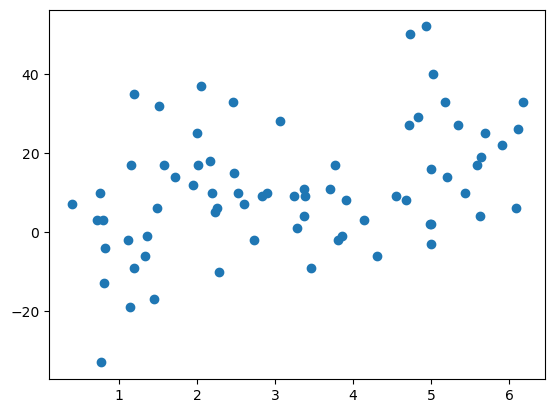

In [16]:
plt.scatter(x=celtics['test_var'],y=celtics['Diff_Points'])

In [17]:
celtics = celtics.drop(columns = 'test_var')

# Machine Learning

In [18]:
after_variables = ['Win','Celtics_Points','Opp_Points','Diff_Points','Total_Points']
bad_variables = ['Date','Opponent']
betting_variables = ['Over_Under','Celtics_Spread_Diff','Celtics_Spread_Payout','Opp_Spread_Diff','Opp_Spread_Payout']

cant_use = after_variables + bad_variables + betting_variables

celtics.head(5)

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Win,Celtics_Points,Opp_Points,Diff_Points,Total_Points,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
1,2023-10-25 00:00:00,New York Knicks,Away,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,True,108,104,4,212,223.0,-3.5,-112,3.5,-108
2,2023-10-27 00:00:00,Miami Heat,Home,False,1.0,NaN,1.0,NaN,NaN,108.000000,NaN,NaN,114.400000,NaN,110.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,1.000000,103.0,True,37.0,0.402,8.0,0.364,21.0,0.808,110.0,108.9,5.0,2.0,2,True,119,111,8,230,217.5,-8.5,-110,8.5,-110
3,2023-10-30 00:00:00,Washington Wizards,Away,False,1.0,1.0,1.0,NaN,NaN,113.500000,NaN,NaN,117.100000,NaN,110.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.500000,113.0,True,40.0,0.430,16.0,0.348,17.0,0.773,111.6,104.7,8.0,3.0,1,True,126,107,19,233,231.5,-10.5,-115,10.5,-105
4,2023-11-01 00:00:00,Indiana Pacers,Home,False,1.0,1.0,1.0,NaN,NaN,117.666667,NaN,NaN,119.333333,NaN,108.966667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,0,0.666667,105.0,False,36.0,0.409,12.0,0.261,21.0,0.840,100.0,103.5,2.0,1.0,4,True,155,104,51,259,233.5,-11.5,-110,11.5,-110
5,2023-11-04 00:00:00,Brooklyn Nets,Away,False,1.0,1.0,1.0,NaN,NaN,127.000000,NaN,NaN,126.575000,NaN,106.600000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2,0.600000,109.0,True,44.0,0.458,18.0,0.400,3.0,0.600,100.0,115.5,4.0,3.0,5,True,124,114,10,238,227.5,-9.5,-110,9.5,-110


## Custom Scoring

#### Learning how to make a scorer

In [19]:
def custom_easy_score(y, y_pred):
    return min(abs(y - y_pred).mean())

easy_scorer = make_scorer(custom_easy_score, greater_is_better=False)

#### Actual Scorer

In [20]:
def custom_profit_score(y, y_pred, celtics_line, celtics_payout, opp_payout, bet=None):
    if bet is None:
        bet = np.ones(len(y))

    if type(bet) in [int, float]:    
        bet = np.ones(len(y)) * bet
    
    bet_on_celtics = y_pred > (celtics_line * -1)
    celtics_win = y > (celtics_line * -1)
    opponent_win = y < (celtics_line * -1)

    payout = ((bet_on_celtics == celtics_win) * (((100/(celtics_payout*-1))*bet*(bet_on_celtics))+((100/(opp_payout*-1))*bet*(1-bet_on_celtics)))) + ((bet_on_celtics == celtics_win) * bet)

    return(sum(payout) - sum(bet))

In [21]:
profit_scorer = make_scorer(custom_profit_score)

#### Testing Scorer

In [22]:
y_fake = np.array([10,4,10,4])
y_pred_fake = np.array([8,8,2,2])
celtics_line_fake = np.array([-6.5,-6.5,-6.5,-6.5])
celtics_payout_fake = np.array([-110,-110,-110,-110])
opp_payout_fake = np.array([-110,-110,-110,-110])
bet_fake = 100

custom_profit_score(y = y_fake,
                    y_pred = y_pred_fake,
                    celtics_line = celtics_line_fake,
                    celtics_payout = celtics_payout_fake,
                    opp_payout = opp_payout_fake,
                    bet = bet_fake)

-18.181818181818187

## Splitting

In [23]:
# the month of april is not a good representation of the season
# the first 10 games are drop for cumulative reasons
celtics = celtics.drop(index=celtics.tail(8).index)
celtics = celtics.drop(index=celtics.head(10).index)

In [24]:
# train on the whole season up to march
X_train = celtics.drop(columns = [col for col in after_variables])
X_train = X_train.drop(index=X_train.tail(16).index)
# X_train
# 48 rows

In [25]:
# predict the month of march
X_test = celtics.drop(columns = [col for col in after_variables])
X_test = X_test.tail(16)
# X_test
# 16 rows

In [26]:
y_train = celtics['Diff_Points']
y_train = y_train.drop(index=celtics.tail(16).index)
# y_train

In [27]:
y_test = celtics['Diff_Points']
y_test = y_test.tail(16)
# y_test

## CV Fold

#### Creating a custom fold

In [28]:
cv_custom = [
    (list(range(0,10,1)),list(range(10,15,1))),
    (list(range(0,15,1)),list(range(15,20,1))),
    (list(range(0,20,1)),list(range(20,25,1))),
    (list(range(5,25,1)),list(range(25,30,1))),
    (list(range(10,30,1)),list(range(30,35,1))),
    (list(range(15,35,1)),list(range(35,40,1))),
    (list(range(20,40,1)),list(range(40,45,1))),
    (list(range(25,45,1)),list(range(45,50,1))),
    (list(range(30,50,1)),list(range(50,55,1))),
    (list(range(33,53,1)),list(range(53,58,1))),
            ]
# cv_custom
# len(cv_custom)
# 10 folds

#### Built in time series split for fold

In [29]:
tscv = TimeSeriesSplit(n_splits=10)
cv = tscv.split(X_train)

#### Uncomment to visualize this fold

In [30]:
# for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
#      print(f"Fold {i}:")
#      print(f"  Train: index={train_index}")
#      print(f"  Test:  index={test_index}")

## Preprocessing

In [31]:
# celtics.info()

In [32]:
# numerical and categorical pipelines
numer_pipe = Pipeline(
    [
        ("imputer",SimpleImputer(strategy='median')),
        ("scaler",StandardScaler())
    ])

cat_pipe = Pipeline(
    [
        ("encoder",OneHotEncoder())
    ])

# numerical and categorical variables to use
numer_variables = celtics.select_dtypes(include='number').columns
numer_variables = [var for var in numer_variables if var not in cant_use]

cat_variables = ['In_Season_Tournament','Opp_Win_Last_Game']

# preprocessing pipeline
preproc_pipe = ColumnTransformer(
    [
        ("numer",numer_pipe,numer_variables),
        ("cat",cat_pipe,cat_variables)
    ],
        remainder='drop')

# preprocessing dataframe
preproc_df = df_after_transform(preproc_pipe,X_train)
print(f"There are {preproc_df.shape[1]} columns in the preprocessed dataframe")
# preproc_df.describe().T.round(2)
# preproc_df

There are 38 columns in the preprocessed dataframe


## Testing Models

In [33]:
pipe = Pipeline(
    [
        ('preproc',preproc_pipe),
        ('feature_select','passthrough'),
        ('clf',Lasso())
    ])
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('numer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Celtics_Win_Pct',
                                                   'Celtics_Home_Win_Pct',
                                                   'Celtics_Away_Win_Pct',
                                                   'Celtics_Win_Pct_Last_5_Games',
                                                   'Celtics_Win_Pct_Last_10_Games',
                                                   'Celtics_Avg_Points_Per_Game',
                                                   'Celtics_Avg_Points_Last_5_Games'...
                                                   'Celtics_Strength_Of_Key_Players_Missing',
                                                   'Opp_Win_Pct',
                                                   'Opp_Points_Last_Game',
                                                   'Opp_FG_Last_Game',
                                                   'Opp_FG_Pct_Last_Game',
                                                   'Opp_3P_Last_Game',
                                                   'Opp_3P_Pct_Last_Game',
                                                   'Opp_FT_Last_Game',
                                                   'Opp_FT_Pct_Last_Game',
                                                   'Opp_Off_Rating_Last_Game', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder())]),
                                                  ['In_Season_Tournament',
                                                   'Opp_Win_Last_Game'])])),
                ('feature_select', 'passthrough'), ('clf', Lasso())])

In [65]:
y_pred = pipe.fit(X_train,y_train).predict(X_test)
r2_score(y_pred,y_test)

-0.03704327089270043

In [34]:
TimeSeriesSplit(n_splits=3).split(X_train)

<generator object TimeSeriesSplit.split at 0x00000129D3CE4770>

In [35]:
X_train = X_train.reset_index().drop(columns='index')

In [36]:
# X_train

In [55]:
def perform_cross_validation(model, X_train, y_train, line, celtics_payout, opp_payout, cv, bet_size):
    scores=[]
    for train_index, test_index in cv.split(X_train):
        X_training, X_testing = X_train.iloc[train_index], X_train.iloc[test_index]
        y_training, y_testing = y_train.iloc[train_index], y_train.iloc[test_index]
        line_test = line.iloc[test_index]
        celtics_payout_test =  celtics_payout.iloc[test_index]
        opp_payout_test =  opp_payout.iloc[test_index]

        model_clone = clone(model)
        ypred = model_clone.fit(X_training, y_training).predict(X_testing)
        score = custom_profit_score(y=y_testing.values, 
                                    y_pred=ypred,
                                    celtics_line=line_test.values,
                                    celtics_payout=celtics_payout_test.values,
                                    opp_payout=opp_payout_test.values,
                                    bet=bet_size)
        scores.append(score)
    return {'scores': scores}


perform_cross_validation(model = pipe,
                         X_train = X_train,
                         y_train = y_train,
                         line = X_train['Celtics_Spread_Diff'],
                         celtics_payout = X_train['Celtics_Spread_Payout'],
                         opp_payout = X_train['Opp_Spread_Payout'],
                         cv = TimeSeriesSplit(n_splits=15),
                         bet_size=200)

{'scores': [-209.52380952380952,
  -209.52380952380952,
  -218.1818181818182,
  -600.0,
  545.4545454545455,
  -218.1818181818182,
  -600.0,
  163.63636363636363,
  -218.1818181818182,
  545.4545454545455,
  -218.1818181818182,
  163.63636363636363,
  163.63636363636363,
  -218.1818181818182,
  545.4545454545455]}

In [56]:
tscv = TimeSeriesSplit(n_splits=15)
for i, (train_index, test_index) in enumerate(tscv.split(X_train)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2]
  Test:  index=[3 4 5]
Fold 1:
  Train: index=[0 1 2 3 4 5]
  Test:  index=[6 7 8]
Fold 2:
  Train: index=[0 1 2 3 4 5 6 7 8]
  Test:  index=[ 9 10 11]
Fold 3:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14]
Fold 4:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
  Test:  index=[15 16 17]
Fold 5:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
  Test:  index=[18 19 20]
Fold 6:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
  Test:  index=[21 22 23]
Fold 7:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
  Test:  index=[24 25 26]
Fold 8:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
  Test:  index=[27 28 29]
Fold 9:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29]
  Test:  index=[30 31 32]
Fold 10:
  Train:

In [59]:
X_train

,Date,Opponent,Home_Away,In_Season_Tournament,Celtics_Win_Pct,Celtics_Home_Win_Pct,Celtics_Away_Win_Pct,Celtics_Win_Pct_Last_5_Games,Celtics_Win_Pct_Last_10_Games,Celtics_Avg_Points_Per_Game,Celtics_Avg_Points_Last_5_Games,Celtics_Avg_Points_Last_10_Games,Celtics_Avg_Off_Rating,Celtics_Avg_Off_Rating_Last_10_Games,Celtics_Avg_Def_Rating,Celtics_Avg_Def_Rating_Last_10_Games,Celtics_Avg_FG_Last_10_Games,Celtics_Avg_FG_Pct_Last_10_Games,Celtics_Avg_3P_Last_10_Games,Celtics_Avg_3P_Pct_Last_10_Games,Celtics_Avg_FT_Last_10_Games,Celtics_Avg_FT_Pct_Last_10_Games,Celtics_Rank_In_Conference,Celtics_Rank_In_Division,Celtics_Strength_Of_Key_Players_Missing,Opp_Win_Pct,Opp_Points_Last_Game,Opp_Win_Last_Game,Opp_FG_Last_Game,Opp_FG_Pct_Last_Game,Opp_3P_Last_Game,Opp_3P_Pct_Last_Game,Opp_FT_Last_Game,Opp_FT_Pct_Last_Game,Opp_Off_Rating_Last_Game,Opp_Def_Rating_Last_Game,Opp_Rank_In_Conference,Opp_Rank_In_Division,Opp_Strength_Of_Key_Players_Missing,Over_Under,Celtics_Spread_Diff,Celtics_Spread_Payout,Opp_Spread_Diff,Opp_Spread_Payout
0,2023-11-15 00:00:00,Philadelphia 76ers,Away,False,0.800000,1.000000,0.600000,0.6,0.8,119.600000,112.8,119.6,121.940000,121.94,107.320000,107.32,43.0,0.4777,16.1,0.3729,17.9,0.7934,1.0,1.0,7,0.800000,126.0,False,43.0,0.500,6.0,0.273,34.0,0.971,116.9,122.4,2.0,2.0,3,223.5,-1.5,-105,1.5,-115
1,2023-11-17 00:00:00,Toronto Raptors,Away,True,0.818182,1.000000,0.666667,0.8,0.8,119.363636,114.4,120.5,122.527273,123.34,108.236364,108.05,43.5,0.4773,16.7,0.3781,16.8,0.7877,1.0,1.0,0,0.454545,112.0,False,38.0,0.396,9.0,0.273,27.0,0.871,117.5,134.3,11.0,5.0,3,224.0,-8.5,-115,8.5,-105
2,2023-11-19 00:00:00,Memphis Grizzlies,Away,False,0.833333,1.000000,0.714286,1.0,0.8,118.416667,115.4,119.4,121.516667,122.40,108.166667,107.62,43.2,0.4756,16.7,0.3719,16.3,0.8082,1.0,1.0,0,0.250000,120.0,True,40.0,0.465,11.0,0.333,29.0,0.806,124.6,112.1,13.0,4.0,8,222.5,-12.5,-110,12.5,-110
3,2023-11-20 00:00:00,Charlotte Hornets,Away,False,0.846154,1.000000,0.750000,1.0,0.8,117.153846,111.6,117.0,120.715385,121.13,108.223077,108.00,41.6,0.4711,16.0,0.3748,17.8,0.8168,1.0,1.0,2,0.250000,108.0,False,40.0,0.488,17.0,0.486,11.0,0.846,112.4,127.0,13.0,4.0,4,234.0,-8.5,-115,8.5,-105
4,2023-11-22 00:00:00,Milwaukee Bucks,Home,False,0.785714,1.000000,0.666667,0.8,0.7,117.214286,111.8,113.3,120.014286,117.39,108.614286,109.42,40.4,0.4576,15.6,0.3497,16.9,0.7847,1.0,1.0,0,0.714286,142.0,True,55.0,0.585,11.0,0.379,21.0,0.750,140.5,127.3,2.0,1.0,0,235.5,-6.5,-105,6.5,-115
5,2023-11-24 00:00:00,Orlando Magic,Away,True,0.800000,1.000000,0.666667,0.8,0.7,117.333333,112.8,112.8,119.826667,116.67,108.986667,109.41,40.5,0.4622,15.8,0.3569,16.0,0.7819,1.0,1.0,1,0.666667,124.0,True,44.0,0.543,10.0,0.345,26.0,0.867,133.8,128.4,4.0,2.0,1,221.0,-5.5,-110,5.5,-110
6,2023-11-26 00:00:00,Atlanta Hawks,Home,False,0.750000,1.000000,0.600000,0.6,0.7,116.000000,108.6,111.5,118.425000,116.49,109.343750,110.51,40.0,0.4639,15.4,0.3528,16.1,0.7784,1.0,1.0,4,0.533333,136.0,True,52.0,0.510,18.0,0.486,14.0,0.700,133.3,105.9,8.0,3.0,2,236.0,-7.5,-115,7.5,105
7,2023-11-28 00:00:00,Chicago Bulls,Home,True,0.764706,1.000000,0.600000,0.6,0.8,115.823529,109.6,112.5,118.341176,117.83,109.182353,110.51,40.6,0.4685,15.2,0.3486,16.1,0.7742,1.0,1.0,3,0.277778,109.0,False,40.0,0.482,12.0,0.375,17.0,0.773,121.0,131.0,13.0,4.0,0,219.5,-12.5,-110,12.5,-110
8,2023-12-01 00:00:00,Philadelphia 76ers,Home,False,0.777778,1.000000,0.600000,0.6,0.8,116.277778,114.0,112.8,118.900000,117.68,108.694444,109.06,41.2,0.4771,15.4,0.3550,15.0,0.7778,1.0,1.0,3,0.666667,114.0,False,42.0,0.519,14.0,0.412,16.0,0.889,115.8,125.9,4.0,2.0,12,218.0,-11.5,-115,11.5,-105
9,2023-12-04 00:00:00,Indiana Pacers,Away,True,0.789474,1.000000,0.600000,0.8,0.8,116.736842,115.4,113.6,119.105263,117.89,109.126316,111.65,40.4,0.4730,15.5,0.3694,17.3,0.8024,1.0,1.0,3,0.555556,144.0,True,56.0,0.659,16.0,0.500,16.0,0.800,144.5,129.4,6.0,2.0,3,244.5,-4.5,-110,4.5,-110


In [ ]:
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.base import clone

def perform_cross_validation(model, X, y, line, celts_payout, opponent_payout, cv):
    scores = []

    for train_index, test_index in cv.split(X):
        X_train, X_test = X[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        line_test = line[test_index]
        celts_payout_test = celts_payout[test_index]
        opponent_payout_test = opponent_payout[test_index]

        model_clone = clone(model)
        ypred = model_clone.fit(X_train, y_train).predict(X_test)
        score = custom_profit_score(y=y_test, 
                                    y_pred=ypred,
                                    celtics_line=line_test,
                                    celtics_payout=celts_payout_test,
                                    opp_payout=opp_payout_test,
                                    bet=100)
        scores.append(score)

    return {'scores': scores}

In [ ]:
# Example usage with TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier

# Example model and data (adjust as needed)
model = Lasso()  # Example classifier
X = pd.DataFrame(np.array([[1, 2], [3, 4], [5, 6], [7, 8]]))  # Sample features
y = np.array([0, 1, 0, 1])  # Sample targets
line = np.array([0.5, 1.5, 0.5, 1.5])
celts_payout = np.array([0.9, 0.9, 0.9, 0.9])
opponent_payout = np.array([1.1, 1.1, 1.1, 1.1])

# Choose your CV strategy
cv_strategy = TimeSeriesSplit(n_splits=3)

# Perform cross-validation
result = perform_cross_validation(model, X, y, line, celts_payout, opponent_payout, cv_strategy)
print(result)

In [ ]:
grid_search = GridSearchCV(
    estimator=pipe,
    scoring=profit_scorer,
    cv=cv,
    param_grid={'clf__alpha': [a for a in np.linspace(0.1,1,5)]})
pd.DataFrame(grid_search.fit(X_train,y_train).cv_results_)

# results = grid_search.fit(X_train,y_train)

In [ ]:
sklearn.metrics.get_scorer_names()